In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, balanced_accuracy_score, confusion_matrix, f1_score
from sklearn.utils import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File paths
csv_file_path = '/content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv'
image_directory = '/content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img'
image_size = (224, 224)

In [ ]:
# Load the CSV file
df = pd.read_csv(csv_file_path)

# Clean up the filenames by removing leading, trailing, and extra spaces in the middle
df['Filename'] = df['Filename'].apply(lambda x: " ".join(x.split()))  # Remove all unnecessary spaces

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(image_filename):
    img_path = os.path.join(image_directory, image_filename)  # Properly join directory and filename
    print(f"Loading image from path: {img_path}")  # Debugging output to check the path
    img = load_img(img_path, target_size=image_size)  # Load and resize image
    img = img_to_array(img) / 255.0  # Convert to array and normalize pixel values
    return img.astype('float32')  # Ensure the image is in float32 format

In [ ]:
# Load all images into an array
images = np.array([load_and_preprocess_image(img_filename) for img_filename in df['Filename'].values])

Streaming output truncated to the last 5000 lines.
Loading image from path: /content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img/HAR_VUN_2022-10-02-10.00-1-161.jpg
Loading image from path: /content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img/HAR_VUN_2022-10-02-10.00-1-1617.jpg
Loading image from path: /content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img/HAR_VUN_2022-10-02-10.00-1-1625.jpg
Loading image from path: /content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img/HAR_VUN_2022-10-02-10.00-1-1633.jpg
Loading image from path: /content/drive/MyDrive/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Air_Pollution_Image_Dataset/Combined_Dataset/All_img/HAR_VUN_2022-10-02-10

In [ ]:
# Re-fill or drop NaNs as before
df['NO2'] = df['NO2'].fillna(df['NO2'].mean())
df['O3'] = df['O3'].fillna(df['O3'].mean())
df.dropna(subset=['NO2', 'O3'], inplace=True)

In [ ]:
# Convert the labels into numpy arrays and ensure they are float32
aqi_values = np.array(df['AQI'].values).astype('float32')
pm25_values = np.array(df['PM2.5'].values).astype('float32')
pm10_values = np.array(df['PM10'].values).astype('float32')
NO2_values = np.array(df['NO2'].values).astype('float32')
O3_values = np.array(df['O3'].values).astype('float32')

In [ ]:
aqi_values = np.clip(aqi_values, 0, 500)
pm25_values = np.clip(pm25_values, 0, 500)
pm10_values = np.clip(pm10_values, 0, 500)
NO2_values = np.clip(NO2_values, 0, 200)
O3_values = np.clip(O3_values, 0, 300)

In [ ]:
# Check shapes to ensure everything is loaded correctly
print(f"Images shape: {images.shape}")
print(f"AQI values shape: {aqi_values.shape}")
print(f"PM2.5 values shape: {pm25_values.shape}")
print(f"PM10 values shape: {pm10_values.shape}")
print(f"NO2 values shape: {NO2_values.shape}")
print(f"O3 values shape: {O3_values.shape}")

Images shape: (12240, 224, 224, 3)
AQI values shape: (12240,)
PM2.5 values shape: (12240,)
PM10 values shape: (12240,)
NO2 values shape: (12240,)
O3 values shape: (12240,)


In [ ]:
# Split the data into training and validation sets (80% train, 20% validation + test)
X_train, X_val, Y_train_aqi, Y_val_aqi, Y_train_pm25, Y_val_pm25, Y_train_pm10, Y_val_pm10, Y_train_NO2, Y_val_NO2, Y_train_O3, Y_val_O3 = train_test_split(
    images, aqi_values, pm25_values, pm10_values, NO2_values, O3_values, test_size=0.2, random_state=42
)

In [ ]:
# Check shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_train_aqi shape: {Y_train_aqi.shape}")
print(f"Y_val_aqi shape: {Y_val_aqi.shape}")
print(f"Y_train_pm25 shape: {Y_train_pm25.shape}")
print(f"Y_val_pm25 shape: {Y_val_pm25.shape}")
print(f"Y_train_pm10 shape: {Y_train_pm10.shape}")
print(f"Y_val_pm10 shape: {Y_val_pm10.shape}")
print(f"Y_train_NO2 shape: {Y_train_NO2.shape}")
print(f"Y_val_NO2 shape: {Y_val_NO2.shape}")
print(f"Y_train_O3 shape: {Y_train_O3.shape}")
print(f"Y_val_O3 shape: {Y_val_O3.shape}")

X_train shape: (9792, 224, 224, 3)
X_val shape: (2448, 224, 224, 3)
Y_train_aqi shape: (9792,)
Y_val_aqi shape: (2448,)
Y_train_pm25 shape: (9792,)
Y_val_pm25 shape: (2448,)
Y_train_pm10 shape: (9792,)
Y_val_pm10 shape: (2448,)
Y_train_NO2 shape: (9792,)
Y_val_NO2 shape: (2448,)
Y_train_O3 shape: (9792,)
Y_val_O3 shape: (2448,)


In [ ]:
# Define the LeakyReLU activation
leaky_relu = tf.keras.layers.LeakyReLU()

# Input Layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

# Block 1: Two CNN layers with 64 filters and one MaxPooling layer
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(input_layer)
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), padding='same')(x)  # Use 'same' padding

# Block 2: Two CNN layers with 128 filters and one MaxPooling layer
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Reduced pool size

# Block 3: Residual block with one CNN layer (128 filters)
residual_1 = x  # Save for residual connection
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.Add()([x, residual_1])  # Residual connection
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Reduced pool size

# Block 4: Residual block with one CNN layer (128 filters)
residual_2 = x
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.Add()([x, residual_2])
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Reduced pool size

# Block 5: Residual block with one CNN layer (128 filters)
residual_3 = x
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=leaky_relu)(x)
x = tf.keras.layers.Add()([x, residual_3])
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Reduced pool size

# Flatten the output for fully connected layers
x = tf.keras.layers.Flatten()(x)

# Fully connected layers (256 and 128 neurons with LeakyReLU activation)
x = tf.keras.layers.Dense(256, activation=leaky_relu)(x)
x = tf.keras.layers.Dense(128, activation=leaky_relu)(x)

# Output layers for AQI, PM2.5, PM10, NO2, and O3
output_aqi = tf.keras.layers.Dense(1, activation='linear', name='AQI')(x)
output_pm25 = tf.keras.layers.Dense(1, activation='linear', name='PM2_5')(x)
output_pm10 = tf.keras.layers.Dense(1, activation='linear', name='PM10')(x)
output_NO2 = tf.keras.layers.Dense(1, activation='linear', name='NO2')(x)
output_O3 = tf.keras.layers.Dense(1, activation='linear', name='O3')(x)

# Define the model with inputs and outputs
model = tf.keras.Model(inputs=input_layer, outputs=[output_aqi, output_pm25, output_pm10, output_NO2, output_O3 ])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')


# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 75, 75, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 75, 75, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 75, 75, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 38, 38, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 38, 38, 128)    │        147,584 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 38, 38, 128)    │              0 │ conv2d_4[0][0],        │
│                           │                        │                │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 19, 19, 128)    │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 19, 19, 128)    │        147,584 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 19, 19, 128)    │              0 │ conv2d_5[0][0],        │
│                           │                        │                │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 10, 10, 128)    │              0 │ add_1[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 10, 10, 128)    │        147,584 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 10, 10, 128)    │              0 │ conv2d_6[0][0],        │
│                           │                        │                │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 5, 5, 128)      │              0 │ add_2[0][0]            │
│ (MaxPooling2D)       

 Total params: 1,555,909 (5.94 MB)

 Trainable params: 1,555,909 (5.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Path to save the model weights during training
weight_path = "/content/drive/MyDrive/Air_Pollution_Image_Dataset/aqi_model.weights.h5"

# Model checkpoints
callback = [
    ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
]


In [ ]:
# Define the filepath for saving the best model (use .keras extension as required)
checkpoint_path = "best_model.keras"

# Callbacks for model checkpointing

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,  # Save only the best model based on validation loss
    save_weights_only=False,  # Save the full model, not just weights
    mode='min'  # Minimize validation loss
)

In [ ]:
# Training parameters
batch_size = 16
epochs = 150

# Model training (ensure X_train, Y_train_aqi, Y_train_pm25, Y_train_pm10, X_val, Y_val_aqi, Y_val_pm25, Y_val_pm10 are defined)
history = model.fit(
    X_train,
    {'AQI': Y_train_aqi, 'PM2_5': Y_train_pm25, 'PM10': Y_train_pm10, 'NO2': Y_train_NO2, 'O3': Y_train_O3},
    validation_data=(X_val, {'AQI': Y_val_aqi, 'PM2_5': Y_val_pm25, 'PM10': Y_val_pm10, 'NO2': Y_val_NO2, 'O3': Y_val_O3}),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint],
    verbose=1
)

# Save the final model after training completes
model.save('final_model.keras')

Epoch 1/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 365.0859 - val_loss: 1808.0656
Epoch 2/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 402.8939 - val_loss: 1829.7312
Epoch 3/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 408.7238 - val_loss: 1800.2184
Epoch 4/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 358.2659 - val_loss: 1789.8623
Epoch 5/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 383.6202 - val_loss: 1958.1044
Epoch 6/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 418.2619 - val_loss: 1735.7510
Epoch 7/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 410.5472 - val_loss: 1767.7543
Epoch 8/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 369.6071 - val_loss: 1786.1841
Epoch 9/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 380.6351 - val_loss: 1843.7222
Epoch 10/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 313.0505 - val_loss: 1744.2379
Epoch 11/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - l

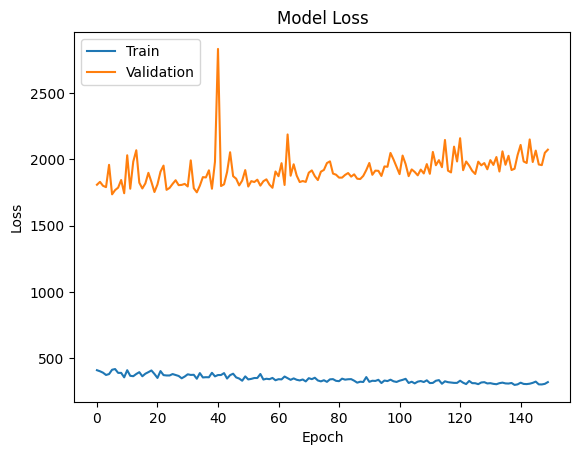

In [ ]:
# Plot training history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
x_origin_test = X_val
y_test = np.column_stack((Y_val_aqi, Y_val_pm25, Y_val_pm10, Y_val_NO2, Y_val_O3))

In [ ]:
# Load the best model weights
weight_path = '/content/final_model.keras'
model.load_weights(weight_path)

# Evaluate the model on test data
loss = model.evaluate(x=x_origin_test, y=y_test, batch_size=16)
print('RMSE is:', loss ** 0.5)

# Predict AQI, PM2.5, and PM10 concentrations
y_predict_aqi, y_predict_pm25, y_predict_pm10, y_predict_NO2, y_predict_O3 = model.predict(x_origin_test)

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11724.6475
RMSE is: 108.35407453690885
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
# --- Calculate R2 Scores for all three outputs ---
print('R2 Score for AQI:', r2_score(y_test[:, 0], y_predict_aqi))
print('R2 Score for PM2.5:', r2_score(y_test[:, 1], y_predict_pm25))
print('R2 Score for PM10:', r2_score(y_test[:, 2], y_predict_pm10))
print('R2 Score for O3:', r2_score(y_test[:, 4], y_predict_O3))
print('R2 Score for NO2:', r2_score(y_test[:, 3], y_predict_NO2))

R2 Score for AQI: 0.9593803882598877
R2 Score for PM2.5: 0.9588901400566101
R2 Score for PM10: 0.9345148205757141
R2 Score for NO2: 0.9191722273826599
R2 Score for O3: 0.9384346604347229


In [ ]:
# --- Classify AQI, PM2.5, PM10, NO2, and O3 predictions into AQI categories ---
def classify_values(values, pollutant_type):
    categories = np.zeros(len(values))

    for i in range(len(values)):  # Indented correctly
        if pollutant_type == 'AQI':
            if values[i] <= 50:
                categories[i] = 0  # Good
            elif 51 <= values[i] <= 100:
                categories[i] = 1  # Moderate
            elif 101 <= values[i] <= 150:
                categories[i] = 2  # Unhealthy for Sensitive Groups
            elif 151 <= values[i] <= 200:
                categories[i] = 3  # Unhealthy
            elif 201 <= values[i] <= 300:
                categories[i] = 4  # Very Unhealthy
            else:
                categories[i] = 5  # Severe

        elif pollutant_type == 'PM2.5':
            if values[i] <= 12.0:
                categories[i] = 0  # Good
            elif 12.1 <= values[i] <= 35.4:
                categories[i] = 1  # Moderate
            elif 35.5 <= values[i] <= 55.4:
                categories[i] = 2  # Unhealthy for Sensitive Groups
            elif 55.5 <= values[i] <= 150.4:
                categories[i] = 3  # Unhealthy
            elif 150.5 <= values[i] <= 250.4:
                categories[i] = 4  # Very Unhealthy
            else:
                categories[i] = 5  # Severe

        elif pollutant_type == 'PM10':
            if values[i] <= 54:
                categories[i] = 0  # Good
            elif 55 <= values[i] <= 154:
                categories[i] = 1  # Moderate
            elif 155 <= values[i] <= 254:
                categories[i] = 2  # Unhealthy for Sensitive Groups
            elif 255 <= values[i] <= 354:
                categories[i] = 3  # Unhealthy
            elif 355 <= values[i] <= 424:
                categories[i] = 4  # Very Unhealthy
            else:
                categories[i] = 5  # Severe

        elif pollutant_type == 'NO2':
            if values[i] <= 53:
                categories[i] = 0  # Good
            elif 54 <= values[i] <= 100:
                categories[i] = 1  # Moderate
            elif 101 <= values[i] <= 360:
                categories[i] = 2  # Unhealthy for Sensitive Groups
            elif 361 <= values[i] <= 649:
                categories[i] = 3  # Unhealthy
            elif 650 <= values[i] <= 1249:
                categories[i] = 4  # Very Unhealthy
            else:
                categories[i] = 5  # Severe

        elif pollutant_type == 'O3':
            if values[i] <= 54:
                categories[i] = 0  # Good
            elif 55 <= values[i] <= 70:
                categories[i] = 1  # Moderate
            elif 71 <= values[i] <= 85:
                categories[i] = 2  # Unhealthy for Sensitive Groups
            elif 86 <= values[i] <= 105:
                categories[i] = 3  # Unhealthy
            elif 106 <= values[i] <= 200:
                categories[i] = 4  # Very Unhealthy
            else:
                categories[i] = 5  # Severe
        else:
            raise ValueError("Unknown pollutant type")

    return categories.astype(int)

In [ ]:
# Apply classification to the predictions
y_predict_aqi_cat = classify_values(y_predict_aqi, 'AQI')
y_predict_pm25_cat = classify_values(y_predict_pm25, 'PM2.5')
y_predict_pm10_cat = classify_values(y_predict_pm10, 'PM10')
y_predict_O3_cat = classify_values(y_predict_O3, 'O3')
y_predict_NO2_cat = classify_values(y_predict_NO2, 'NO2')

In [ ]:
# Apply classification to the ground truth
y_test_aqi_cat = classify_values(y_test[:, 0], 'AQI')
y_test_pm25_cat = classify_values(y_test[:, 1], 'PM2.5')
y_test_pm10_cat = classify_values(y_test[:, 2], 'PM10')
y_test_O3_cat = classify_values(y_test[:, 4], 'O3')
y_test_NO2_cat = classify_values(y_test[:, 3], 'NO2')

In [ ]:
# --- Classification Accuracy for AQI, PM2.5, PM10, NO2, and O3 ---
def calculate_accuracy(y_true, y_pred):
    t = np.sum(y_true == y_pred)
    n = len(y_true) - t
    acc = t / len(y_true)
    return acc, t, n

In [ ]:
# Calculate accuracy for AQI, PM2.5, PM10, NO2, and O3
acc_aqi, t_aqi, n_aqi = calculate_accuracy(y_test_aqi_cat, y_predict_aqi_cat)
acc_pm25, t_pm25, n_pm25 = calculate_accuracy(y_test_pm25_cat, y_predict_pm25_cat)
acc_pm10, t_pm10, n_pm10 = calculate_accuracy(y_test_pm10_cat, y_predict_pm10_cat)
acc_O3, t_O3, n_O3 = calculate_accuracy(y_test_O3_cat, y_predict_O3_cat)
acc_NO2, t_NO2, n_NO2 = calculate_accuracy(y_test_NO2_cat, y_predict_NO2_cat)

print(f'AQI Classification Accuracy: {acc_aqi}, True: {t_aqi}, False: {n_aqi}')
print(f'PM2.5 Classification Accuracy: {acc_pm25}, True: {t_pm25}, False: {n_pm25}')
print(f'PM10 Classification Accuracy: {acc_pm10}, True: {t_pm10}, False: {n_pm10}')
print(f'O3 Classification Accuracy: {acc_O3}, True: {t_O3}, False: {n_O3}')
print(f'NO2 Classification Accuracy: {acc_NO2}, True: {t_NO2}, False: {n_NO2}')

# --- F1 Scores for AQI, PM2.5, PM10, NO2, and O3 ---
f1_aqi = f1_score(y_test_aqi_cat, y_predict_aqi_cat, average='macro')
f1_pm25 = f1_score(y_test_pm25_cat, y_predict_pm25_cat, average='macro')
f1_pm10 = f1_score(y_test_pm10_cat, y_predict_pm10_cat, average='macro')
f1_NO2 = f1_score(y_test_NO2_cat, y_predict_NO2_cat, average='macro')
f1_O3 = f1_score(y_test_O3_cat, y_predict_O3_cat, average='macro')

print(f'F1 Score for AQI: {f1_aqi}')
print(f'F1 Score for PM2.5: {f1_pm25}')
print(f'F1 Score for PM10: {f1_pm10}')
print(f'F1 Score for O3: {f1_O3}')
print(f'F1 Score for NO2: {f1_NO2}')

AQI Classification Accuracy: 0.8035130718954249, True: 1967, False: 481
PM2.5 Classification Accuracy: 0.8468137254901961, True: 2073, False: 375
PM10 Classification Accuracy: 0.8729575163398693, True: 2137, False: 311
NO2 Classification Accuracy: 0.9325980392156863, True: 2283, False: 165
O3 Classification Accuracy: 0.9138071895424836, True: 2237, False: 211
F1 Score for AQI: 0.8093322833026981
F1 Score for PM2.5: 0.743048023002513
F1 Score for PM10: 0.7998277363779924
F1 Score for NO2: 0.6604693975018671
F1 Score for O3: 0.7418131448829587


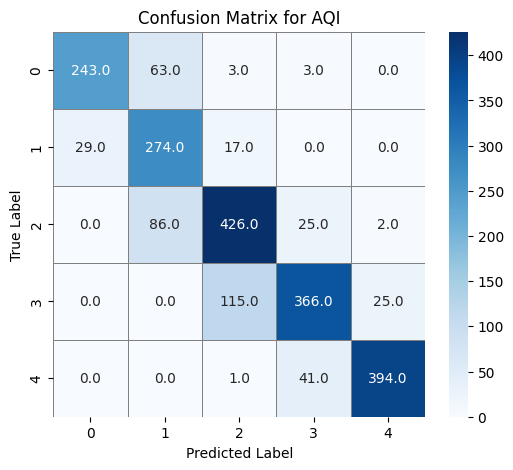

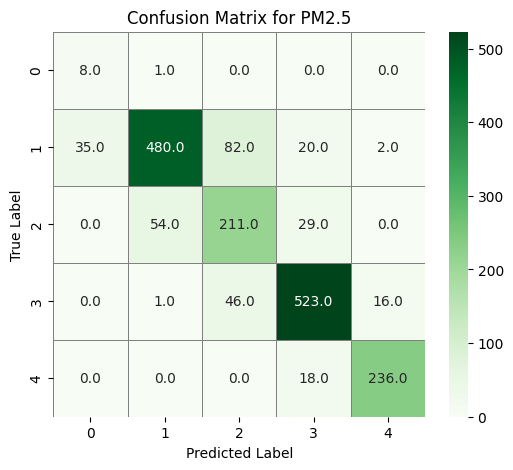

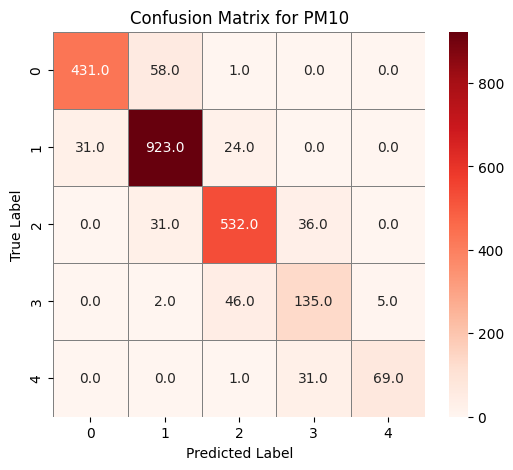

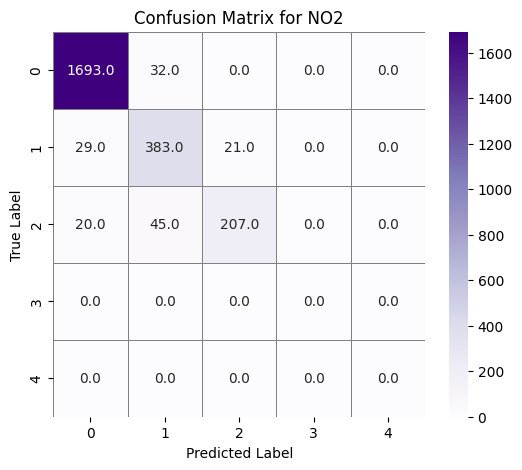

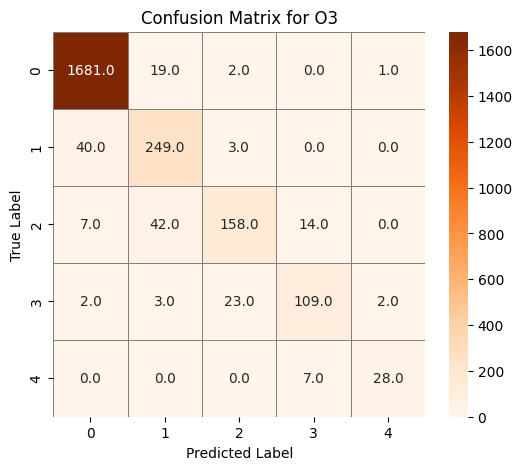

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Updated function for a 5x5 confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, cmap):
    # Ensure the confusion matrix is 5x5 by specifying labels [0, 1, 2, 3, 4]
    confusion_mtx = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])
    f, ax = plt.subplots(figsize=(6, 5))  # Adjusted size for a 5x5 grid
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.5, cmap=cmap, linecolor="gray", fmt='.1f', ax=ax,
                xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Color maps for each confusion matrix
aqi_cmap = "Blues"    # Blue color map for AQI
pm25_cmap = "Greens"  # Green color map for PM2.5
pm10_cmap = "Reds"    # Red color map for PM10
NO2_cmap = "Purples"  # Purple color map for NO2
O3_cmap = "Oranges"   # Orange color map for O3

# Plot 5x5 confusion matrices with different colors for each pollutant
plot_confusion_matrix(y_test_aqi_cat, y_predict_aqi_cat, "AQI", aqi_cmap)
plot_confusion_matrix(y_test_pm25_cat, y_predict_pm25_cat, "PM2.5", pm25_cmap)
plot_confusion_matrix(y_test_pm10_cat, y_predict_pm10_cat, "PM10", pm10_cmap)
plot_confusion_matrix(y_test_O3_cat, y_predict_O3_cat, "O3", O3_cmap)
plot_confusion_matrix(y_test_NO2_cat, y_predict_NO2_cat, "NO2", NO2_cmap)

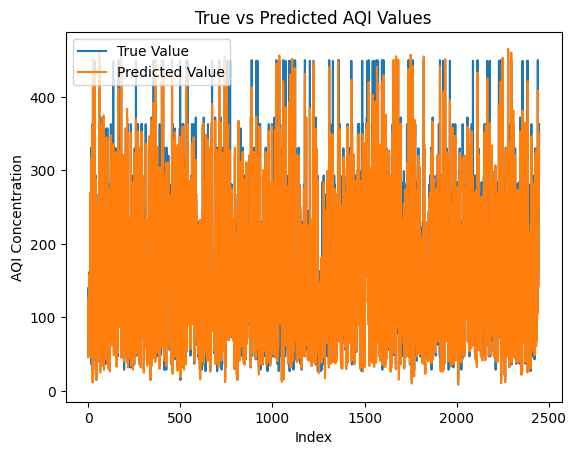

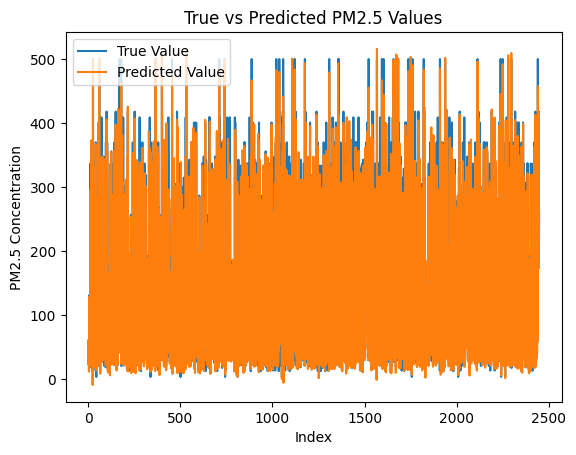

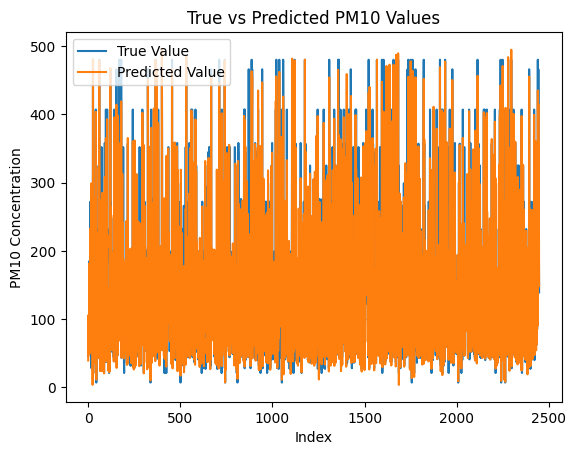

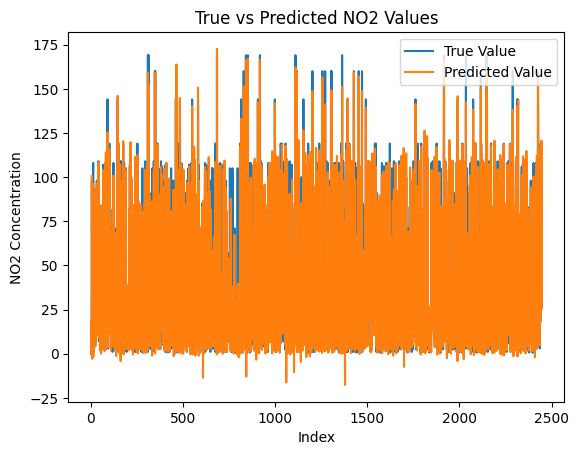

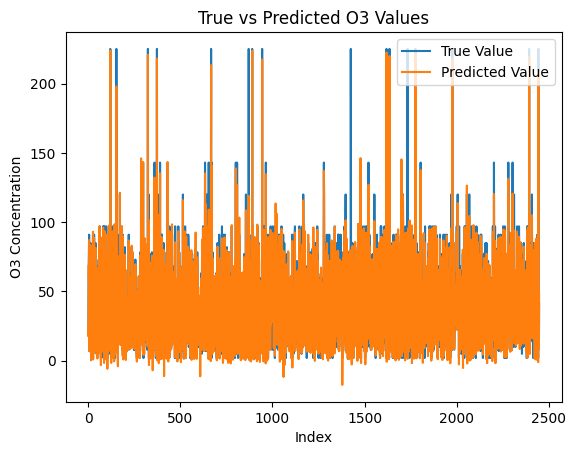

In [ ]:
# --- Plot True vs Predicted Values for AQI, PM2.5, PM10, NO2, and O3 ---
def plot_true_vs_predicted(y_true, y_pred, title):
    plt.plot(y_true, label='True Value')
    plt.plot(y_pred, label='Predicted Value')
    plt.xlabel('Index')
    plt.ylabel(f'{title} Concentration')
    plt.title(f'True vs Predicted {title} Values')
    plt.legend()
    plt.show()

# Plot true vs predicted values
plot_true_vs_predicted(y_test[:, 0], y_predict_aqi, "AQI")     # AQI
plot_true_vs_predicted(y_test[:, 1], y_predict_pm25, "PM2.5")  # PM2.5
plot_true_vs_predicted(y_test[:, 2], y_predict_pm10, "PM10")   # PM10
plot_true_vs_predicted(y_test[:, 4], y_predict_O3, "O3")       # O3
plot_true_vs_predicted(y_test[:, 3], y_predict_NO2, "NO2")       # NO2